<html>
   <body>
       <h1 style="text-align:center;">Multimodal Efficient Coding Integration</h1>
       <hr>
       <p style="text-align:center;">A Jupyter Notebook demonstration of the efficient coding principle across various sensory modalities. (black and white images, color images, and audio). Code for modalities adapted from COMP386 coursework and tutorials.</p>
       <hr>
      <h2>Table of Contents</h2>
       <br>
       <li> <a href='#bw'>Black and White Images</a>
        <ul style="list-style-type: circle">
		 	<li>PCA/ICA for Natural Images </li>
            <li>PCA/ICA for Unnatural Images </li>
		 </ul> 
    </li>
    <li><a href='#c'>Color Images</a> 
        <ul style="list-style-type: circle">
		 	<li>PCA/ICA for Natural Images </li>
            <li>PCA/ICA for Unnatural Images </li>
		 </ul> 
    </li>
    <li><a href='#bi'>Binocular Images</a> 
        <ul style="list-style-type: circle">
		 	<li>PCA/ICA for Natural Images </li>
            <li>PCA/ICA for Unnatural Images </li>
		 </ul> 
    </li> 
    <li><a href='#audio'>Audio</a> 
        <ul style="list-style-type: circle">
		 	<li>PCA/ICA for Natural Sounds </li>
            <li>PCA/ICA for Unnatural Sounds </li>
		 </ul> 
    </li>   
    <li><a href='#final'>Conclusion Figures</a> 
    </li> 
   <hr>
   <h3>Background and Motivation</h3>
   <hr>
   <p>The lowest level of stimuli processing in the brain across several sensory modalities can be modeled using the same algorithm regardless of the kind of input. This demonstrates the <b>efficient coding hypothesis.</b>
  <br>

Efficient encoding states that the brain aims to minimize energy usage via independent coding, which attempts to minimize redundancy among firing neurons while producing this code. Thus, when one neuron fires the the receptive field it is representing varies from those represented by other neurons. This is well represented by <b>Independent Components Analysis</b>.
  
This presentation aims to display the efficient coding hypothesis through modeling sensory processing that occurs on black and white vision, color vision, hearing, and binocular vision utilizing the same algorithm regardless of input.</p>
    
   </body>
	
</html>

<hr>
<a id='bw'></a>
<h1>Black and White Vision</h1>
<hr>
These functions are for collecting patches from black and white images and then displaying them in order to show what they look like once PCA and ICA have been run. Black and white images are used to represent low-level processing in the primary visual cortex (V1).

<img src="figures/v1.png" width="75%" height="75%">

<hr>
If we were to look at a single V1 simple neural cell, said cell would be sensitive to stimuli in a particular position and orientation. This is also referred to as a gabor filter. We would know this from said cell's receptive field, which is the area of sensory space that causes said neuron to fire.  For example, in looking at the below example of a live recorded V1 simple cell receptive field, it would fire in response to the spatial frequency and orientation of the visual pattern in the green box, not the red box. 

<img src="figures/firing.png" width="75%" height="75%">

In [2]:
#Folded here are all the packages used in the notebook
import numpy as np
import pylab as py 
%matplotlib inline 
from IPython.display import Image, Audio
import math
import sklearn.decomposition 
from sklearn import decomposition
import PIL
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import pylab
from scipy import ndimage
import matplotlib
import wave
import sys
import random as random

For our purposes, what are the steps to efficient coding?
First, we must collect sensory data and extract random samples, or in our case patches. This is done in our <b> collectPatchesBW</b> function below.

In [3]:
# this function collects patches from black and white images
def collectPatchesBW(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    imgPatches = np.zeros([numPixels,numPatches],'double')                                          
    # chooses the image that we're sampling from
    imgCount = 1  
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from to the next in the folder
            imgCount += 1
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
            firstPatch = patchCount
            firstTry = tryCount
        #starts patch collection in a random space
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)
        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()
        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1  
    return imgPatches

In [4]:
#this function displays black and white image patches
def showPatchesBW(prePatches, showPatchNum = 16, display=True):
    patches = prePatches
    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))
    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum
        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()
    bw = 5    # border width
    pw = patchWidth
    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY
        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
    return

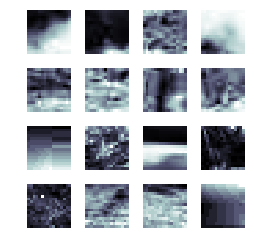

In [43]:
patchesBWNatural = collectPatchesBW(50000, 16, 'BW/natural/')
showPatchesBW(patchesBWNatural)

<hr>
Once we've collected sensory data and extracted patches, the next step is to apply an encoding algorithm to derive the proper neural coding strategy, and then display the resulting filters that represent receptive fields. In the case of neural efficiency, the proper algorithm is Independent Components Analysis (ICA). 

Why ICA? Here, ICA works to find feature that are as statistically independent as possible, which closely resembles how the brain minimizes redundancy among firing neurons via efficient encoding. 
<hr>
For each modality, we show ICA in comparison to Principal Components Analysis (PCA), which attempts to find combos of features that best explain the variance in the data. This would be perfect for representing computer-like efficiency, where we could minimize usage of hardware. However this is not representative of neural efficiency, as its impossible to minimize neurons. 
<hr>

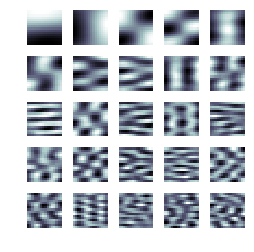

In [35]:
pcatemp = sklearn.decomposition.PCA(n_components=50)
pcafit = pcatemp.fit(np.transpose(patchesBWNatural))

pca_comp = pcafit.components_
showPatchesBW(np.transpose(pca_comp), 25)

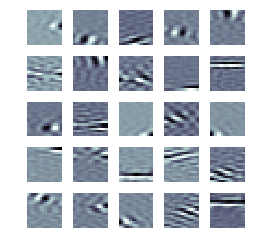

In [44]:
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWNatural))

ica_comp = icafit.components_
showPatchesBW(np.transpose(ica_comp), 25)

<hr>
Notice that in some of these resulting filter patches, the results look familiar. Thats because they resemble live recorded V1 simple cell receptive fields! For example, below is a modeled receptive field produced through this code in contrast to a recorded one. These are both sensitive to the same orientation and spatial frequency.

<img src="figures/modelvslive.png" width="100%" height="100%">
<hr>

What happens when you apply the same code to "non-natural" images? The difference between natural and unnatural images has to do with what our brains have evolved to process over time, as well as shared statistical properties. For our purposes, natural images would consist of scenery such as forests and praries, while unnatural images would consist of white noise patterns. These would not produce neural-like filters.

<a id='bwun'></a>

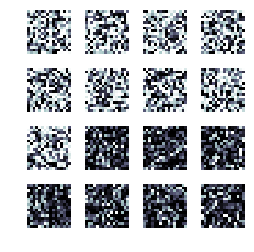

In [8]:
patchesBWUnnatural = collectPatchesBW(50000, 16, 'BW/unnatural/')
showPatchesBW(patchesBWUnnatural)

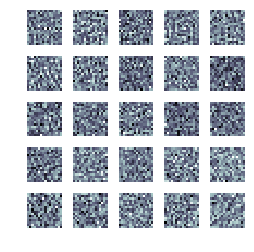

In [9]:
pcatemp = sklearn.decomposition.PCA(n_components=50)
pcafit = pcatemp.fit(np.transpose(patchesBWUnnatural))

pca_comp = pcafit.components_
showPatchesBW(np.transpose(pca_comp), 25)

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


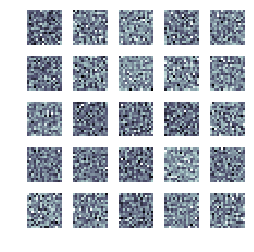

In [10]:
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWUnnatural))

ica_comp = icafit.components_
showPatchesBW(np.transpose(ica_comp), 25)

<a id='c'></a>
<hr>
<a id='bw'></a>
<h1>Color Vision</h1>
<hr>
We typically do not see the world in greyscale, so how is color represented and processed efficiently? Despite slightly different input given that we are now accounting for a third domain of info, RGB, our method of modeling efficient coding does not vary. We are still collecting data, extracting patches, applying the appropriate encoding strategy, and displaying the resulting neural filters.

In [11]:
# this function collects patches from color images
def collectPatchesColor(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    imageWidth = 200
    firstPatch = 0  # the first patch number accepted from an image
    firstTry = 0  # the first attempt to take a patch from the image
    patchCount = 0  # number of collected patches
    tryCount = 0  # number of attempted collected patches
    numPixels = 3 * patchWidth * patchWidth
    patchSample = np.zeros([3, patchWidth, patchWidth], float)
    patch = np.zeros([numPixels], float)
    imgPatches = np.zeros([numPixels, numPatches], float)
  # this chooses the image we're sampling from, starting from the first image
    imgCount = 1
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    image = np.asarray(image, 'double').transpose()
    image = image[0:3, :, :]
  # normalizing the image
    image -= image.mean()
    image /= image.std()
  # collect the patches from images in file
    while patchCount < numPatches and tryCount < maxTries:
        tryCount += 1  # number of total patches attempted
        if tryCount - firstTry > maxTries / 2 or patchCount \
            - firstPatch > numPatches / 2:
            imgCount += 1  # this switches to the next image we're sampling from!
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
            image = np.asarray(image, 'double').transpose()
            image = image[0:3, :, :]
            image -= image.mean()
            image /= image.std()
            firstPatch = patchCount
            firstTry = tryCount
        px = np.random.randint(0, imageWidth - patchWidth)
        py = np.random.randint(0, imageWidth - patchWidth)
        patchSample = image[:, px:px + patchWidth, py:py
                            + patchWidth].copy()
        patch_std = patchSample.std()
        if patch_std > 0.0:  # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector
            patch = np.reshape(patchSample, numPixels)
            patch = patch - np.mean(patch)
            imgPatches[:, patchCount] = patch.copy()
            patchCount += 1
    return imgPatches

In [12]:
#this function displays color image patches
def showPatchesColor(prePatches, showPatchNum=16, display=True):
    patches = prePatches
    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim))) - 6
  # extract showPatchNum patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0, showPatchNum):
        patch_i = i * totalPatches // showPatchNum
        patch = patches[:, patch_i].copy()
        pmax = patch.max()
        pmin = patch.min()
    # fix patch range from min to max to 0 to 1
        if pmax > pmin:
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:, i] = patch.copy()
    bw = 5  # border width
    pw = patchWidth
    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([3, (pw + bw) * patchesX
            - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0, showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY
    # reshape patch sizing
        reshaped = displayPatch[:, i].reshape((3, 8, 8))
        fullPatch = np.zeros([3, pw, pw], float)
        fullPatch[0:3, 0:8, 0:8] = reshaped[:, :, :].copy()
        patchImg[:, x_i * (pw + bw):x_i * (pw + bw) + pw, y_i * (pw
                 + bw):y_i * (pw + bw) + pw] = fullPatch
    if display:
    # displays the patches
        py.imshow(patchImg[:, :, :].T, interpolation='nearest')
        py.axis('off')
    return

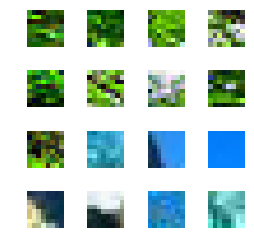

In [24]:
patchesColorNatural = collectPatchesColor(10000, 8, 'color/natural/')
showPatchesColor(patchesColorNatural)

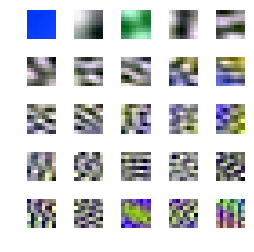

In [25]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=50)
pcafit = pcatemp.fit(np.transpose(patchesColorNatural))

pca_comp = pcafit.components_
showPatchesColor(np.transpose(pca_comp), 25)

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


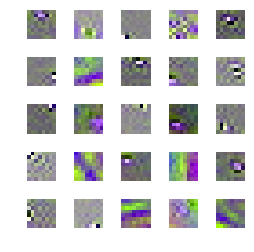

In [26]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorNatural))

ica_comp_c = icafit_c.components_
showPatchesColor(np.transpose(ica_comp_c), 25)

Here, we once again see gabor filters as a result of using ICA that mirror recorded simple cell receptive fields. The main difference that we see between here and black and white images is some green and blue, which reflects Opponent-Process Theory. We see predominantly greyscale as the brain prioritizes luminance of visual stimuli.
<hr>
In comparison to "non-natural" color images, which for our purposes includes psychedelic images never seen in natural settings, the produced filter do not look neural. 

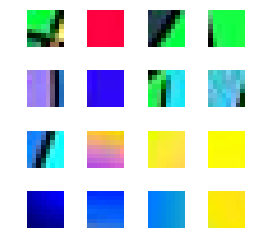

In [16]:
patchesColorUnnatural = collectPatchesColor(10000, 8, 'color/unnatural/')
showPatchesColor(patchesColorUnnatural)

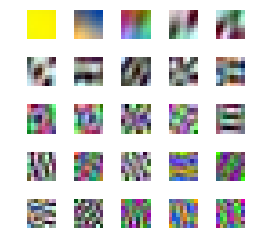

In [17]:
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesColorUnnatural))

pca_comp = pcafit.components_
showPatchesColor(np.transpose(pca_comp), 25)

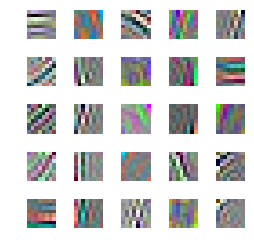

In [18]:
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorUnnatural))

ica_comp_c = icafit_c.components_
showPatchesColor(np.transpose(ica_comp_c), 25)

<a id='bi'></a>

<hr>
<a id='bw'></a>
<h1>Binocular Vision</h1>
<hr>
The way we view the world is via binocular vision through both eyes. In modeling V1 simple cell filters while representing this, below we are showing patches in the following format, where the left column represents the left visual field and the right column representing the right.
<hr>
Our process for efficient coding is the same as black and white and color vision, where we are taking in images, this time one for the left visual field and one for the right visual field. In natural binocular images, this would be two images of the same subject, but one image is shifted from the other to represent the difference in visual fields. 
<img src="figures/naturalbi.png" width="100%" height="100%">
<hr>
Unnatural binocular images for our purposes are images of completely different scenes, or two duplicate images. What we expect to see for natural binocular images after ICA filtering is the same filters from left to right, only shifted slightly in position.
<hr>

In [54]:
#Image file import as well as methods for sampling and delinearizing
imageL = PIL.Image.open('BI/1.png')
imageL = imageL.convert('L')
imageL = np.array(imageL, 'double')

imageR = PIL.Image.open('BI/2.png')
imageR = imageR.convert('L')
imageR = np.array(imageR, 'double')

#natural, to compare the same image
imageS = PIL.Image.open('BI/un.png')
imageS = imageS.convert('L')
imageS = np.array(imageS, 'double')

imageS2 = PIL.Image.open('BI/un.png')
imageS2 = imageS2.convert('L')
imageS2 = np.array(imageS2, 'double')

#natural, comparing previous image to this one (2 completely different images)
imageD = PIL.Image.open('BI/un2.png')
imageD = imageD.convert('L')
imageD = np.array(imageD, 'double')

patches = []
patches2 = []
patches3 = []
def sample_comb3(dims, nsamp):
    idx = sample_without_replacement(np.prod(dims), nsamp)
    return np.vstack(np.unravel_index(idx, dims)).T

def delinearize(array):
    size = sqrt(len(array))
    outarray = []
    temp = []
    counter = 1
    for i in range(len(array)):
        if size != counter:
            temp.append(array[i])
            counter += 1
        else:
            outarray.append(temp)
            temp=[]
            counter=1
    return outarray



In [55]:
def collectPatchesBI(image1, image2, patchArray):
    patch_size = 8
    num_patches = 100000
    num_max_possible_patches = (len(image1)-patch_size) * (len(image1[0])-patch_size)
    num_max_patches = min(num_patches, num_max_possible_patches)
    num_max_tries = min(num_patches*1.2, num_max_possible_patches)

    # indices = pickRandom(num_max_tries, 1, len(img)-patch_size, 1, len(img[0])-patch_size)
    indices = sample_comb3([len(image1)-patch_size, len(image1[0])-patch_size], num_max_tries)


    cnt = 0
    for idx in indices:
        if cnt >= num_max_patches:
            break
        x = idx[0]
        y = idx[1]
        temp = []
        temp2 = []
        for i in range(patch_size):
            for j in range(patch_size):
                temp.append(image1[x+i][y+j])
                temp2.append(image2[x+i][y+j])
        mtemp = temp + temp2   
        if np.std(temp) > 0:
            patchArray.append(mtemp)

            cnt = cnt + 1

    # print "patches size: "
    print ("patches size: ", len(patchArray), " x ", len(patchArray[0]))

In [56]:
def showPatchesBI(patch):
    num_components = 10
    k=0
    #patch from left and right side img
    fig = py.figure(figsize=(5,30))
    for i in range(num_components):
        k = k+1
        fig.add_subplot(10,2,k)
        py.imshow(delinearize(patch[i][0:64]),interpolation='nearest',cmap=py.get_cmap('gray'))
        py.axis("off")
        k = k+1
        fig.add_subplot(10,2,k)
        py.imshow(delinearize(patch[i][64:]),interpolation='nearest',cmap=py.get_cmap('gray'))
        py.axis("off")

patches size:  100000  x  128


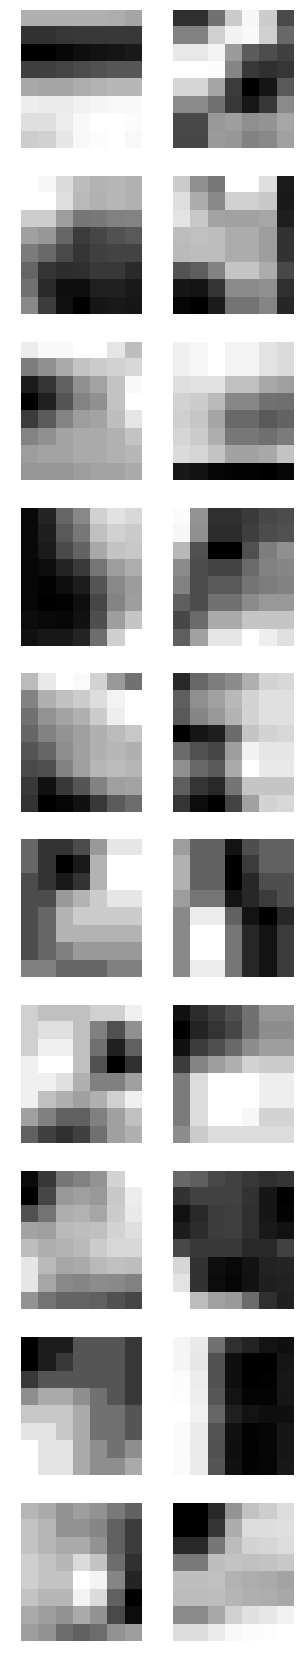

In [57]:
#natural binocular
collectPatchesBI(imageL, imageR, patches)
showPatchesBI(patches)

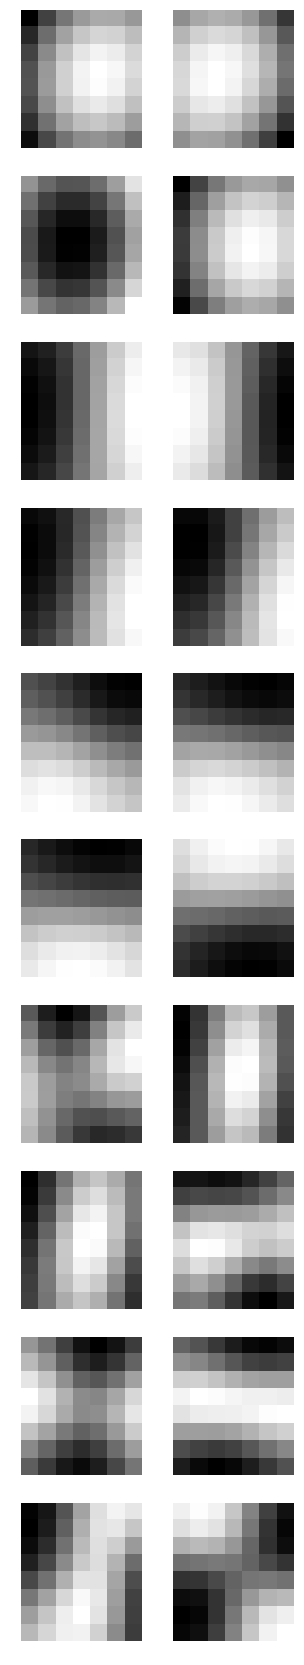

In [58]:
#pca natural
pcatemp = decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(patches)
pcacomp = pcafit.components_
showPatchesBI(pcacomp)

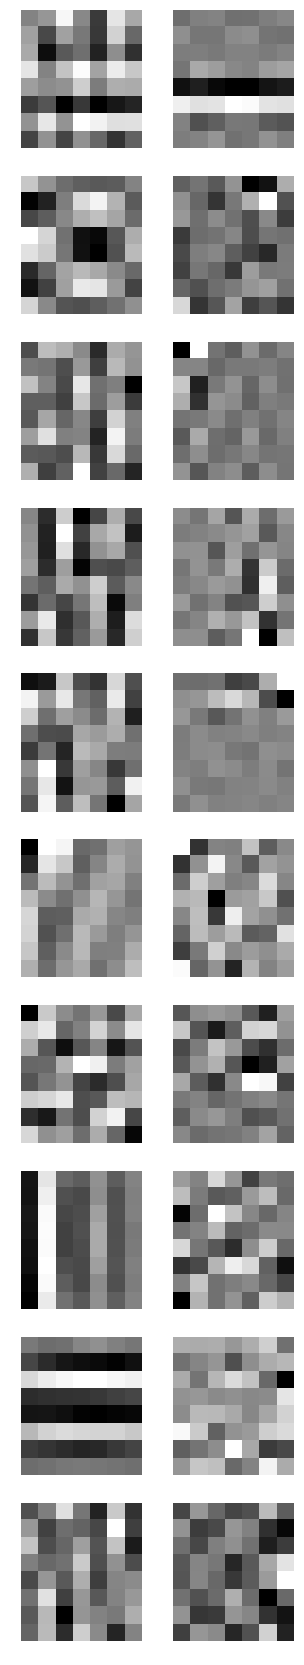

In [59]:
#ica natural
icatemp = decomposition.FastICA(n_components=75)
icafit = icatemp.fit(patches)
icacomp = icafit.components_
showPatchesBI(icacomp)

patches size:  100000  x  128


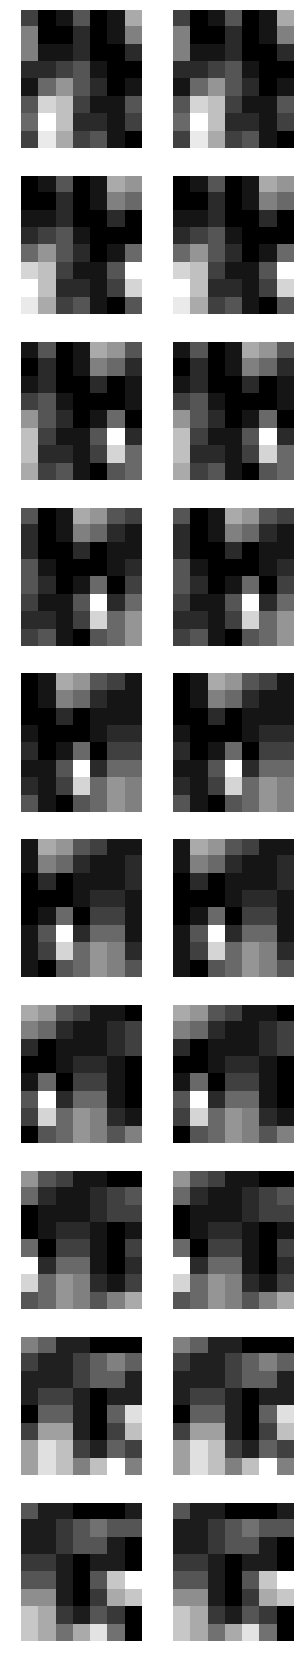

In [60]:
#duplicate image
collectPatchesBI(imageS, imageS2, patches2)
showPatchesBI(patches2)

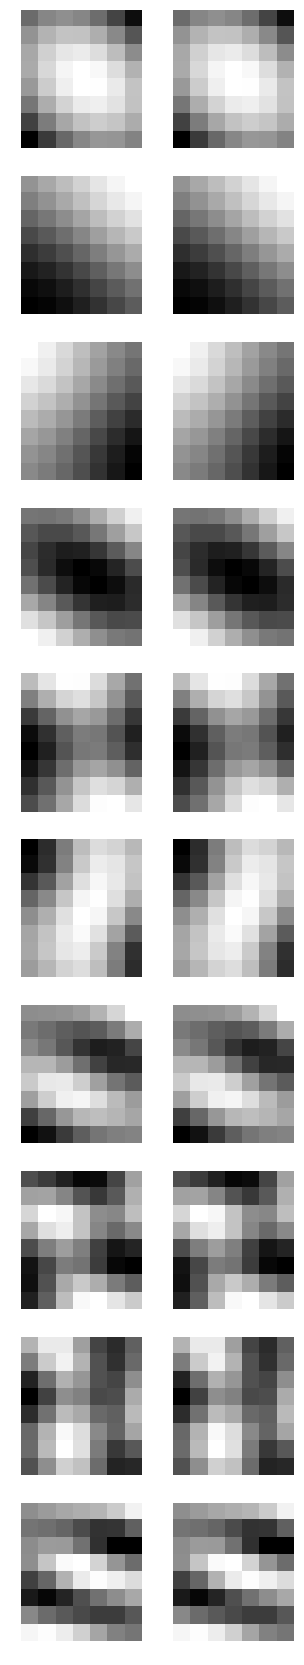

In [61]:
#pca same
pcatemp = decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(patches2)
pcacomp = pcafit.components_
showPatchesBI(pcacomp)

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


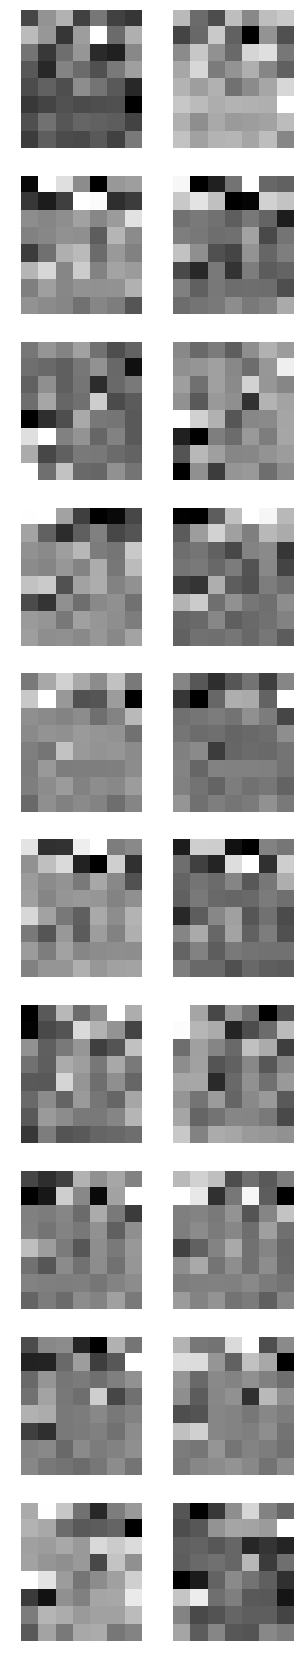

In [62]:
#ica same
icatemp = decomposition.FastICA(n_components=75)
icafit = icatemp.fit(patches2)
icacomp = icafit.components_
showPatchesBI(icacomp)

patches size:  100000  x  128


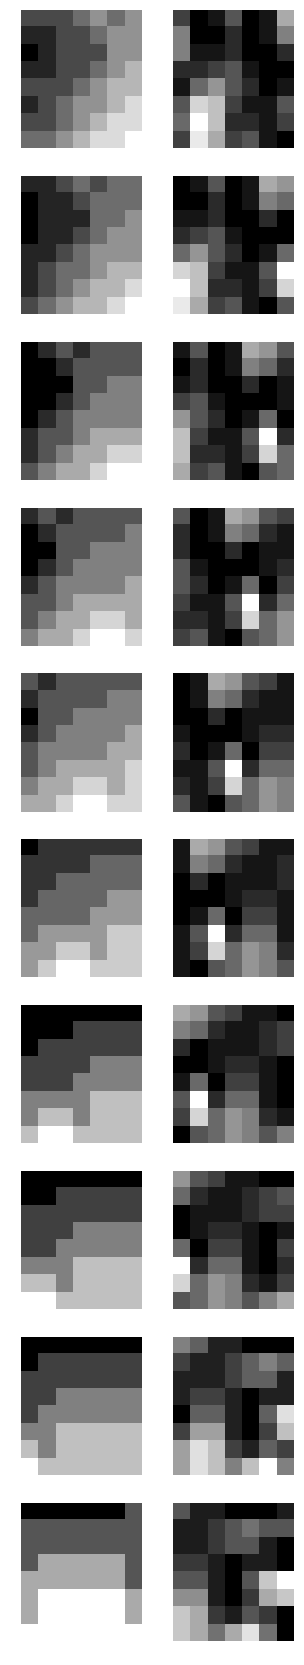

In [63]:
#different images
collectPatchesBI(imageD, imageS2, patches3)
showPatchesBI(patches3)

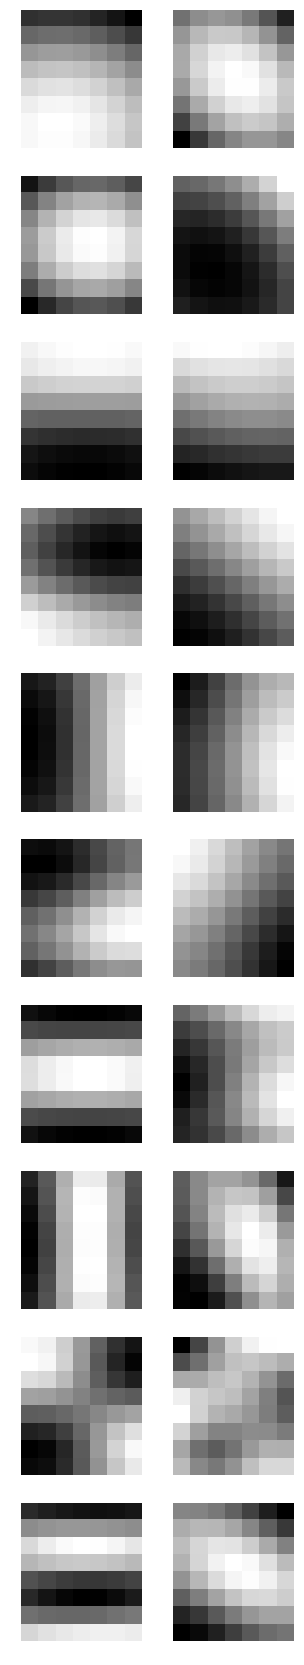

In [64]:
#pca diff
pcatemp = decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(patches3)
pcacomp = pcafit.components_
showPatchesBI(pcacomp)

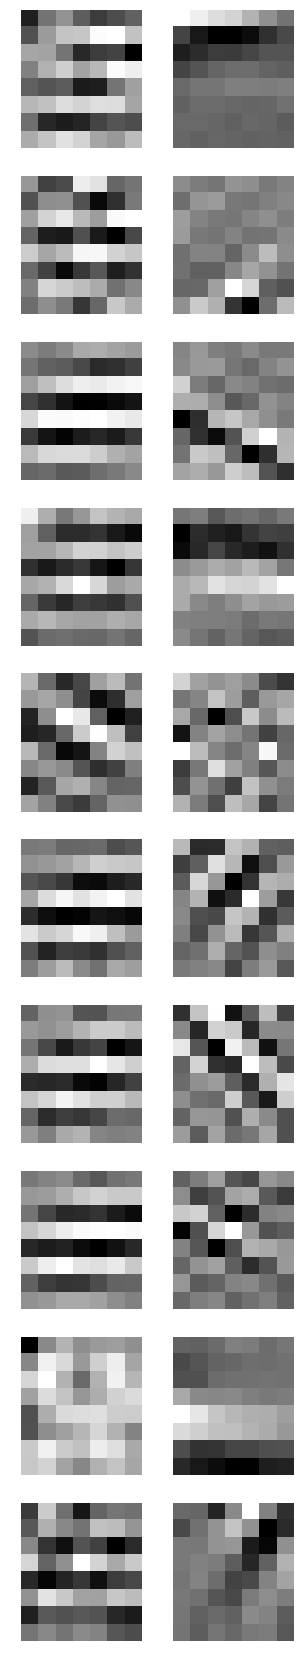

In [65]:
#ica diff
icatemp = decomposition.FastICA(n_components=75)
icafit = icatemp.fit(patches3)
icacomp = icafit.components_
showPatchesBI(icacomp)

<a id='audio'></a>
<hr>
<h1>Hearing</h1>
<hr>
What happens if we try to apply the efficient coding hypothesis to a completely different sensory modality, such as hearing? Here we are attempting to model low-level processing that occurs in the auditory nerve. Recordered filters that occur here look like this, and are known as <b>gammatone filters.</b>

<img src="figures/gamma.png" width="75%" height="75%">
<hr>
Here we have the same efficient coding steps as before. We collect an audio clip, and then extract random patches. We then apply our encoding algorithm to derive filters, and display the resulting filters.

In [63]:
#this function collects patches from audio clips
def collectPatchesAudio(file):
    spf = wave.open('audio/' + file + '.wav','r')
    # extract raw audio from .wav file
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, 'Int16')
    fs = spf.getframerate()
    print(fs)
    numSamples = len(signal)  
    width = 100
    ds = 3
    numPatches = 10000
    audioPatches = np.zeros((numPatches,width))
    for i in range(numPatches):
        x_start = np.random.randint(0,numSamples-ds*width-2)
        audioPatches[i,:] = signal[x_start:x_start+ds*width-1:ds]
    return(audioPatches)

In [64]:
#this function displays audio patches
def showPatchesAudio(patches):
    width = 100
    cnt = 0
    for cnt in range(20):
        plt.subplot(5, 5, cnt+1)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.plot(range(width),patches[cnt,:])
    plt.show()

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


44100


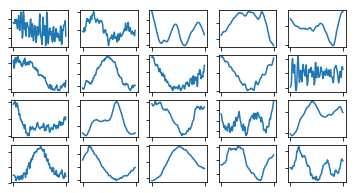

In [65]:
naturalSound = collectPatchesAudio('bill')
showPatchesAudio(naturalSound)

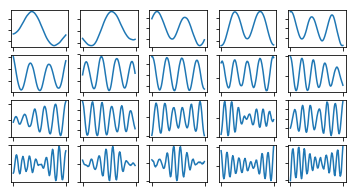

In [66]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(naturalSound)

pca_comp = pcafit.components_
showPatchesAudio(pca_comp)

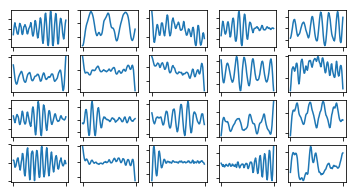

In [73]:
# finding ICA components 
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(naturalSound)

ica_comp = icafit.components_
showPatchesAudio(ica_comp)

Here, our "natural" sound clip example comes from a speech. When we run PCA and ICA, we can see that some of the resulting audio patches resemble the gabor filter as shown previously. Resulting PCA filters do not reflect neural responses.
<hr>
<img src="figures/gamma2.png" width="100%" height="100%">
<hr>
Note that in unnatural soundclips, such as for pure whitenoise, gammatone filters are no longer extracted.

/Users/angiegeorgaras/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


44100


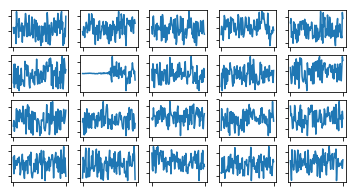

In [300]:
unnaturalSound = collectPatchesAudio('whitenoise')
showPatchesAudio(unnaturalSound)

In [ ]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(unnaturalSound)

pca_comp = pcafit.components_
showPatchesAudio(pca_comp)

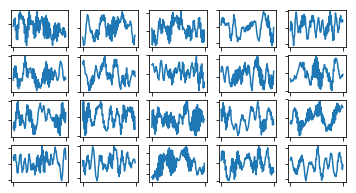

In [145]:
# finding ICA components 
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(unnaturalSound)

ica_comp = icafit.components_
showPatchesAudio(ica_comp)

<a id='final'></a>
<a id='audio'></a>
<hr>
<h1>Conclusions</h1>
<hr>
This project is intended as an introduction to this concept via utilizing a tutorial-style Jupyter notebook programmed in Python to students with and without any prior programming experience. Below are the filters derived from this project displayed in tiled format. 

<img src="figures/conclusionsvisual.png" width="75%" height="75%">
<img src="figures/audiofigure.png" width="75%" height="75%">
<hr>
